<a href="https://colab.research.google.com/github/xthazudp/Admin-Dashboard/blob/master/FRQI_NEQR_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit qiskit_aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 115.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.1/126.1 kB 15.3 MB/s eta 0:00:00


In [ ]:
from qiskit.circuit.library import RYGate
import numpy as np

# Apply Hadamard to qubits in n
def hadamard(circ, n):
    for i in n:
        circ.h(i)

# Compare two binary strings, return indices where they differ
def change(state, new_state):
    n = len(state)
    c = []
    for i in range(n):
        if state[i] != new_state[i]:
            c.append(i)
    return np.array(c, dtype=int)

# Apply X gates on differing bits
def binary(circ, state, new_state):
    c = change(state, new_state)
    if len(c) > 0:
        n_bits = len(state)
        circ.x([n_bits - 1 - idx for idx in c])

# Controlled multi-qubit Ry gate
def cnri(circ, n, t, theta):
    controls = len(n)
    cry = RYGate(2*theta).control(controls)
    aux = np.append(n, t).tolist()
    circ.append(cry, aux)

# FRQI encoding
def frqi(circ, n, t, angles):
    hadamard(circ, n)
    j = 0
    for i in angles:
        state = '{0:06b}'.format(j-1) if j > 0 else '000000'
        new_state = '{0:06b}'.format(j)
        if j == 0:
            cnri(circ, n, t, i)
        else:
            binary(circ, state, new_state)
            cnri(circ, n, t, i)
        j += 1


MSE (padded 32×32): 2755.6592


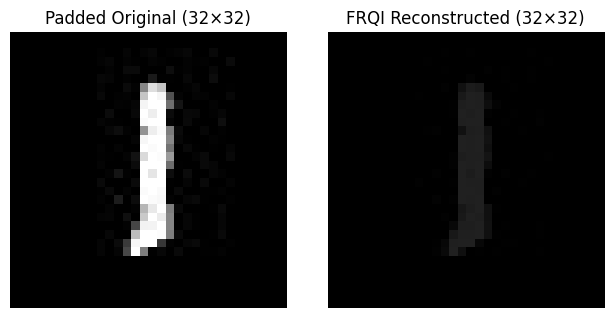

In [ ]:
# ===================== Image → Blocks → FRQI → Reconstruct =====================
import cv2
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_aer import Aer
from qiskit.circuit.library import RYGate
from sklearn.metrics import mean_squared_error

# --------- (1) Small fix in binary(): make it work for any number of address qubits ---------
def binary(circ, state, new_state):
    # state/new_state are bitstrings (e.g., '000000'); flip qubits that changed.
    c = change(state, new_state)  # indices from left→right in the bitstring
    if len(c) > 0:
        n_bits = len(state)
        # Map bitstring index to qubit index: leftmost bit controls the highest-index address qubit
        # If your address qubits are [0,1,...,n-1], and state bits are b_(n-1) ... b_0
        # flip qubit (n-1 - bit_index)
        circ.x([n_bits - 1 - idx for idx in c])

# --------- (2) Helper: run FRQI on a single 8×8 block and retrieve it back ---------
def process_block(block8x8, shots=65536):
    """
    block8x8: np.ndarray shape (8,8), dtype uint8 or float in [0,255]
    returns: reconstructed 8x8 np.ndarray dtype uint8
    """
    # Normalize to [0,1] and map to angles via arcsin (consistent with your code)
    norm_block = (block8x8.astype(np.float64) / 255.0)
    angles = np.arcsin(norm_block.flatten())  # length 64

    # 6 address qubits for 8×8 (2^6 = 64), 1 color qubit
    addr_qubits = list(range(6))   # [0..5]
    color_qubit = 6                # target
    qr = QuantumRegister(7, 'q')
    cr = ClassicalRegister(7, 'c')
    qc = QuantumCircuit(qr, cr)

    # FRQI encode
    frqi(qc, addr_qubits, color_qubit, angles)

    # Measure (keep same order as your original code to match bitstrings)
    qc.measure([0,1,2,3,4,5,6], [0,1,2,3,4,5,6])

    # Simulate
    backend = Aer.get_backend('qasm_simulator')
    tqc = transpile(qc, backend=backend)
    result = backend.run(tqc, shots=shots).result()
    counts = result.get_counts(qc)

    # Retrieve pixel amplitudes from counts:
    # We expect keys as bitstrings for 7 measured bits. In your scheme the leftmost bit is the color qubit.
    # For pixel index i, we look for string: '1' + format(i, '06b')
    retrieved = np.zeros(64, dtype=np.float64)
    for i in range(64):
        s = format(i, '06b')
        key = '1' + s
        p1 = counts.get(key, 0) / shots
        # amplitude ≈ sin(theta) = normalized pixel value
        retrieved[i] = np.sqrt(p1)  # same as your original reconstruction

    # Scale back to [0,255]
    retrieved *= 255.0
    block_rec = np.clip(np.round(retrieved), 0, 255).astype(np.uint8).reshape(8, 8)
    return block_rec

# --------- (3) Load your 28×28 grayscale image and pad to 32×32 ---------
# Replace "digit.png" with your 28×28 grayscale image path
img28 = cv2.imread("/content/14.jpg", cv2.IMREAD_GRAYSCALE)
if img28 is None:
    raise FileNotFoundError("Could not read the image. Make sure 'digit.png' exists and is grayscale (28×28).")
if img28.shape != (28, 28):
    # If not exactly 28×28, resize to 28×28 to follow your requirement
    img28 = cv2.resize(img28, (28, 28), interpolation=cv2.INTER_NEAREST)

# Pad evenly to 32×32 (2 pixels on each side)
padded32 = np.pad(img28, ((2, 2), (2, 2)), mode='constant', constant_values=0)

# --------- (4) Split into sixteen 8×8 blocks (4×4 grid) ---------
blocks = []
for i in range(0, 32, 8):
    for j in range(0, 32, 8):
        blocks.append(padded32[i:i+8, j:j+8])
blocks = np.array(blocks)  # shape (16, 8, 8)

# --------- (5) Run FRQI encode/decode per block ---------
reconstructed_blocks = []
shots_per_block = 65536  # adjust if you want faster runs (e.g., 16384) or more accuracy
# shots_per_block = 1048576
for b in blocks:
    reconstructed_blocks.append(process_block(b, shots=shots_per_block))
reconstructed_blocks = np.array(reconstructed_blocks).reshape(4, 4, 8, 8)

# --------- (6) Merge blocks back to a single 32×32 image ---------
reconstructed32 = np.block([[reconstructed_blocks[i, j] for j in range(4)] for i in range(4)])
reconstructed32 = reconstructed32.astype(np.uint8)

# --------- (7) (Optional) Compute quality metrics on padded (not the original 28×28) ---------
mse = mean_squared_error(padded32.flatten(), reconstructed32.flatten())
print(f"MSE (padded 32×32): {mse:.4f}")

# --------- (8) Visualize ---------
fig, axs = plt.subplots(1, 2, figsize=(6.5, 3.2))
axs[0].imshow(padded32, cmap='gray', vmin=0, vmax=255)
axs[0].set_title("Padded Original (32×32)")
axs[0].axis('off')
axs[1].imshow(reconstructed32, cmap='gray', vmin=0, vmax=255)
axs[1].set_title("FRQI Reconstructed (32×32)")
axs[1].axis('off')
plt.tight_layout()
plt.show()

✅ Pixel values saved to pixel_values_FRQI.csv

Overall MSE (padded 32×32): 2763.4150


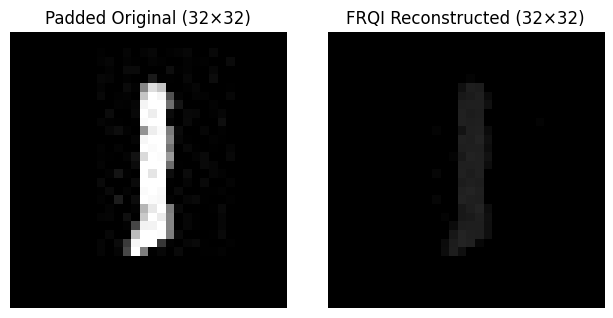

In [ ]:
# ===================== Image → Blocks → FRQI → Reconstruct with Pixel CSV Export =====================
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_aer import Aer
from qiskit.circuit.library import RYGate
from sklearn.metrics import mean_squared_error

# --------- FRQI encoder ---------
def frqi(circ, addr_qubits, color_qubit, angles):
    n_addr = len(addr_qubits)
    circ.h(addr_qubits)
    for i, theta in enumerate(angles):
        b = format(i, f'0{n_addr}b')
        for idx, bit in enumerate(b):
            if bit == '0':
                circ.x(addr_qubits[n_addr - 1 - idx])
        circ.mcry(2 * theta, addr_qubits, color_qubit)
        for idx, bit in enumerate(b):
            if bit == '0':
                circ.x(addr_qubits[n_addr - 1 - idx])

# --------- Modified process_block with CSV recording ---------
def process_block(block8x8, block_id, shots=4096):
    records = []

    # Before normalization
    orig_vals = block8x8.flatten()

    # Normalize
    norm_block = (block8x8.astype(np.float64) / 255.0)
    norm_vals = norm_block.flatten()

    angles = np.arcsin(norm_vals)

    # 6 address qubits + 1 color qubit
    qr = QuantumRegister(7, 'q')
    cr = ClassicalRegister(7, 'c')
    qc = QuantumCircuit(qr, cr)

    # Encode
    frqi(qc, list(range(6)), 6, angles)

    # Measure
    qc.measure([0,1,2,3,4,5,6], [0,1,2,3,4,5,6])

    # Simulate
    backend = Aer.get_backend('qasm_simulator')
    tqc = transpile(qc, backend=backend)
    result = backend.run(tqc, shots=shots).result()
    counts = result.get_counts(qc)

    # Decode
    retrieved = np.zeros(64, dtype=np.float64)
    for i in range(64):
        key = '1' + format(i, '06b')
        p1 = counts.get(key, 0) / shots
        retrieved[i] = np.sqrt(p1)

    # Scale back
    rec_vals = np.clip(np.round(retrieved * 255.0), 0, 255).astype(np.uint8)

    # Save each pixel’s journey in records
    for idx in range(64):
        records.append({
            "Block": block_id,
            "PixelIndex": idx,
            "Original(0-255)": orig_vals[idx],
            "Normalized(0-1)": norm_vals[idx],
            "Reconstructed(0-255)": rec_vals[idx]
        })

    # Return block and records
    return rec_vals.reshape(8, 8), records

# --------- Load 28×28 grayscale, pad to 32×32 ---------
img28 = cv2.imread("/content/14.jpg", cv2.IMREAD_GRAYSCALE)
if img28 is None:
    raise FileNotFoundError("Could not read the image.")
if img28.shape != (28, 28):
    img28 = cv2.resize(img28, (28, 28), interpolation=cv2.INTER_NEAREST)

padded32 = np.pad(img28, ((2, 2), (2, 2)), mode='constant', constant_values=0)

# --------- Split into 8×8 blocks ---------
blocks = []
for i in range(0, 32, 8):
    for j in range(0, 32, 8):
        blocks.append(padded32[i:i+8, j:j+8])
blocks = np.array(blocks)

# --------- Encode/Decode ---------
reconstructed_blocks = []
all_records = []
for block_id, b in enumerate(blocks):
    block_rec, records = process_block(b, block_id, shots=4096)
    reconstructed_blocks.append(block_rec)
    all_records.extend(records)

reconstructed_blocks = np.array(reconstructed_blocks).reshape(4, 4, 8, 8)

# --------- Merge blocks ---------
reconstructed32 = np.block([[reconstructed_blocks[i, j] for j in range(4)] for i in range(4)]).astype(np.uint8)

# --------- Save to CSV ---------
df = pd.DataFrame(all_records)
df.to_csv("pixel_values_FRQI.csv", index=False)
print("✅ Pixel values saved to pixel_values_FRQI.csv")

# --------- Metrics ---------
mse = mean_squared_error(padded32.flatten(), reconstructed32.flatten())
print(f"\nOverall MSE (padded 32×32): {mse:.4f}")

# --------- Visualization ---------
fig, axs = plt.subplots(1, 2, figsize=(6.5, 3.2))
axs[0].imshow(padded32, cmap='gray', vmin=0, vmax=255)
axs[0].set_title("Padded Original (32×32)")
axs[0].axis('off')
axs[1].imshow(reconstructed32, cmap='gray', vmin=0, vmax=255)
axs[1].set_title("FRQI Reconstructed (32×32)")
axs[1].axis('off')
plt.tight_layout()
plt.show()


✅ Pixel values saved to pixel_values_FRQI.csv

Overall MSE (padded 32×32): 2752.2705


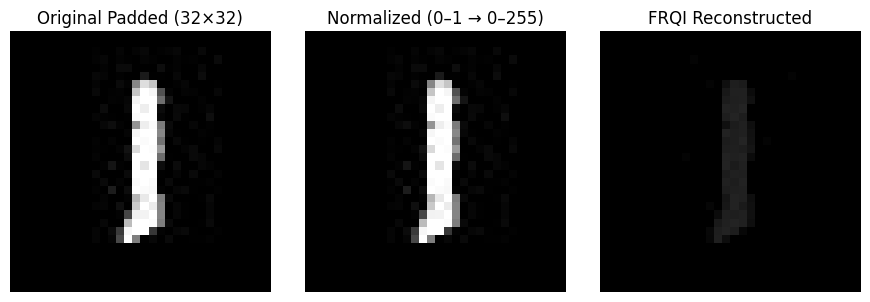

In [ ]:
# ===================== Image → Blocks → FRQI → Reconstruct with CSV + Visualization =====================
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_aer import Aer
from qiskit.circuit.library import RYGate
from sklearn.metrics import mean_squared_error

# --------- FRQI encoder ---------
def frqi(circ, addr_qubits, color_qubit, angles):
    n_addr = len(addr_qubits)
    circ.h(addr_qubits)
    for i, theta in enumerate(angles):
        b = format(i, f'0{n_addr}b')
        for idx, bit in enumerate(b):
            if bit == '0':
                circ.x(addr_qubits[n_addr - 1 - idx])
        circ.mcry(2 * theta, addr_qubits, color_qubit)
        for idx, bit in enumerate(b):
            if bit == '0':
                circ.x(addr_qubits[n_addr - 1 - idx])

# --------- Modified process_block with CSV recording ---------
def process_block(block8x8, block_id, shots=4096):
    records = []

    # Original pixel values
    orig_vals = block8x8.flatten()

    # Normalize
    norm_block = block8x8.astype(np.float64) / 255.0
    norm_vals = norm_block.flatten()

    angles = np.arcsin(norm_vals)

    # 6 address qubits + 1 color qubit
    qr = QuantumRegister(7, 'q')
    cr = ClassicalRegister(7, 'c')
    qc = QuantumCircuit(qr, cr)

    # Encode
    frqi(qc, list(range(6)), 6, angles)

    # Measure
    qc.measure([0,1,2,3,4,5,6], [0,1,2,3,4,5,6])

    # Simulate
    backend = Aer.get_backend('qasm_simulator')
    tqc = transpile(qc, backend=backend)
    result = backend.run(tqc, shots=shots).result()
    counts = result.get_counts(qc)

    # Decode
    retrieved = np.zeros(64, dtype=np.float64)
    for i in range(64):
        key = '1' + format(i, '06b')
        p1 = counts.get(key, 0) / shots
        retrieved[i] = np.sqrt(p1)

    # Scale back
    rec_vals = np.clip(np.round(retrieved * 255.0), 0, 255).astype(np.uint8)

    # Save each pixel’s journey in records
    for idx in range(64):
        records.append({
            "Block": block_id,
            "PixelIndex": idx,
            "Original(0-255)": orig_vals[idx],
            "Normalized(0-1)": norm_vals[idx],
            "Reconstructed(0-255)": rec_vals[idx]
        })

    return rec_vals.reshape(8, 8), records

# --------- Load 28×28 grayscale, pad to 32×32 ---------
img28 = cv2.imread("/content/14.jpg", cv2.IMREAD_GRAYSCALE)
if img28 is None:
    raise FileNotFoundError("Could not read the image.")
if img28.shape != (28, 28):
    img28 = cv2.resize(img28, (28, 28), interpolation=cv2.INTER_NEAREST)

padded32 = np.pad(img28, ((2, 2), (2, 2)), mode='constant', constant_values=0)

# For visualization: normalized image mapped back to 0–255
normalized_vis = np.round((padded32.astype(np.float64)/255.0)*255).astype(np.uint8)

# --------- Split into 8×8 blocks ---------
blocks = []
for i in range(0, 32, 8):
    for j in range(0, 32, 8):
        blocks.append(padded32[i:i+8, j:j+8])
blocks = np.array(blocks)

# --------- Encode/Decode ---------
reconstructed_blocks = []
all_records = []
for block_id, b in enumerate(blocks):
    block_rec, records = process_block(b, block_id, shots=4096)
    reconstructed_blocks.append(block_rec)
    all_records.extend(records)

reconstructed_blocks = np.array(reconstructed_blocks).reshape(4, 4, 8, 8)
reconstructed32 = np.block([[reconstructed_blocks[i, j] for j in range(4)] for i in range(4)]).astype(np.uint8)

# --------- Save to CSV ---------
df = pd.DataFrame(all_records)
df.to_csv("pixel_values_FRQI.csv", index=False)
print("✅ Pixel values saved to pixel_values_FRQI.csv")

# --------- Compute MSE ---------
mse = mean_squared_error(padded32.flatten(), reconstructed32.flatten())
print(f"\nOverall MSE (padded 32×32): {mse:.4f}")

# --------- Visualization ---------
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
axs[0].imshow(padded32, cmap='gray', vmin=0, vmax=255)
axs[0].set_title("Original Padded (32×32)")
axs[0].axis('off')

axs[1].imshow(normalized_vis, cmap='gray', vmin=0, vmax=255)
axs[1].set_title("Normalized (0–1 → 0–255)")
axs[1].axis('off')

axs[2].imshow(reconstructed32, cmap='gray', vmin=0, vmax=255)
axs[2].set_title("FRQI Reconstructed")
axs[2].axis('off')

plt.tight_layout()
plt.show()

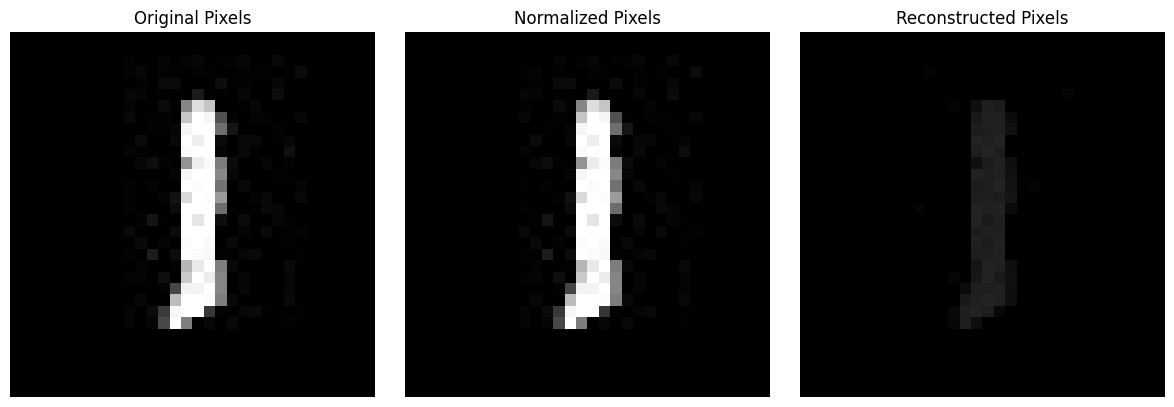

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --------- Load CSV ---------
df = pd.read_csv("pixel_values_FRQI.csv")

# Determine image size: 16 blocks of 8x8 → 32x32
img_size = 32
block_size = 8
blocks_per_row = img_size // block_size

# Initialize empty images
original_img = np.zeros((img_size, img_size), dtype=np.uint8)
normalized_img = np.zeros((img_size, img_size), dtype=np.uint8)
reconstructed_img = np.zeros((img_size, img_size), dtype=np.uint8)

# --------- Fill images from CSV ---------
for _, row in df.iterrows():
    block_id = int(row['Block'])
    pixel_idx = int(row['PixelIndex'])

    # Block row/col
    block_row = block_id // blocks_per_row
    block_col = block_id % blocks_per_row

    # Pixel row/col inside block
    pixel_row = pixel_idx // block_size
    pixel_col = pixel_idx % block_size

    # Absolute position in 32x32 image
    r = block_row * block_size + pixel_row
    c = block_col * block_size + pixel_col

    # Fill values
    original_img[r, c] = row['Original(0-255)']
    normalized_img[r, c] = int(row['Normalized(0-1)'] * 255)  # map back to 0-255 for display
    reconstructed_img[r, c] = row['Reconstructed(0-255)']

# --------- Plot ---------
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(original_img, cmap='gray', vmin=0, vmax=255)
axs[0].set_title("Original Pixels")
axs[0].axis('off')

axs[1].imshow(normalized_img, cmap='gray', vmin=0, vmax=255)
axs[1].set_title("Normalized Pixels")
axs[1].axis('off')

axs[2].imshow(reconstructed_img, cmap='gray', vmin=0, vmax=255)
axs[2].set_title("Reconstructed Pixels")
axs[2].axis('off')

plt.tight_layout()
plt.show()

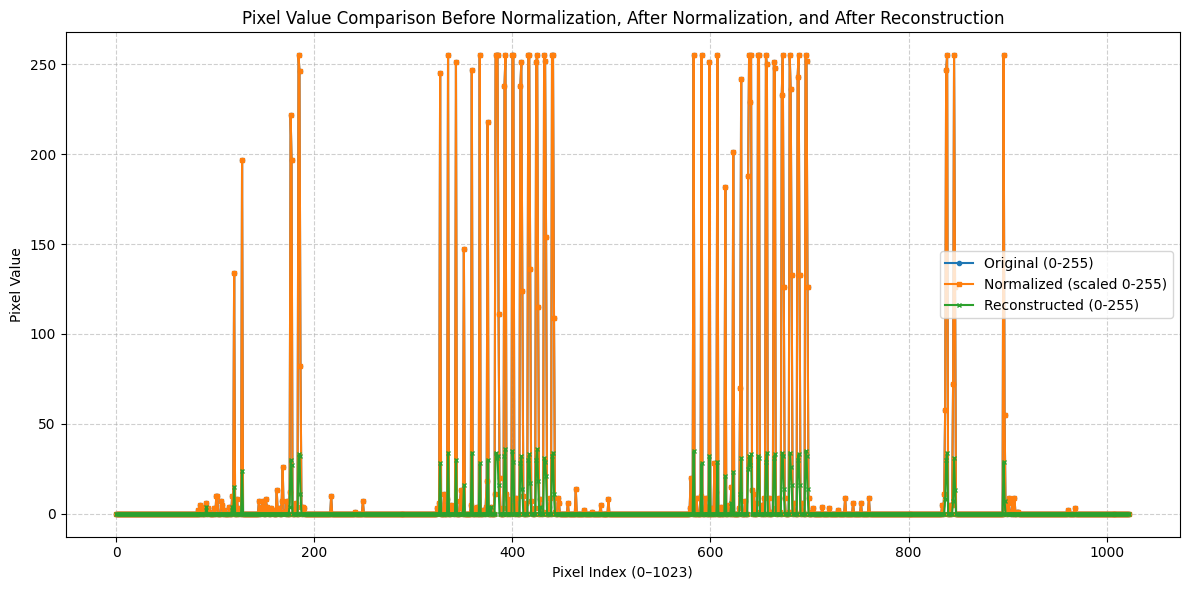

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --------- Load CSV ---------
df = pd.read_csv("pixel_values_FRQI.csv")

# To keep consistent ordering across the whole 32×32 image
df_sorted = df.sort_values(by=["Block", "PixelIndex"]).reset_index(drop=True)

# Extract values
orig_vals = df_sorted["Original(0-255)"].values
norm_vals = df_sorted["Normalized(0-1)"].values * 255   # scaled for comparison
rec_vals = df_sorted["Reconstructed(0-255)"].values
pixels = range(len(orig_vals))  # 1024 pixels

# --------- Plot ---------
plt.figure(figsize=(12, 6))

plt.plot(pixels, orig_vals, 'o-', markersize=3, label="Original (0-255)")
plt.plot(pixels, norm_vals, 's-', markersize=3, label="Normalized (scaled 0-255)")
plt.plot(pixels, rec_vals, 'x-', markersize=3, label="Reconstructed (0-255)")

plt.xlabel("Pixel Index (0–1023)")
plt.ylabel("Pixel Value")
plt.title("Pixel Value Comparison Before Normalization, After Normalization, and After Reconstruction")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

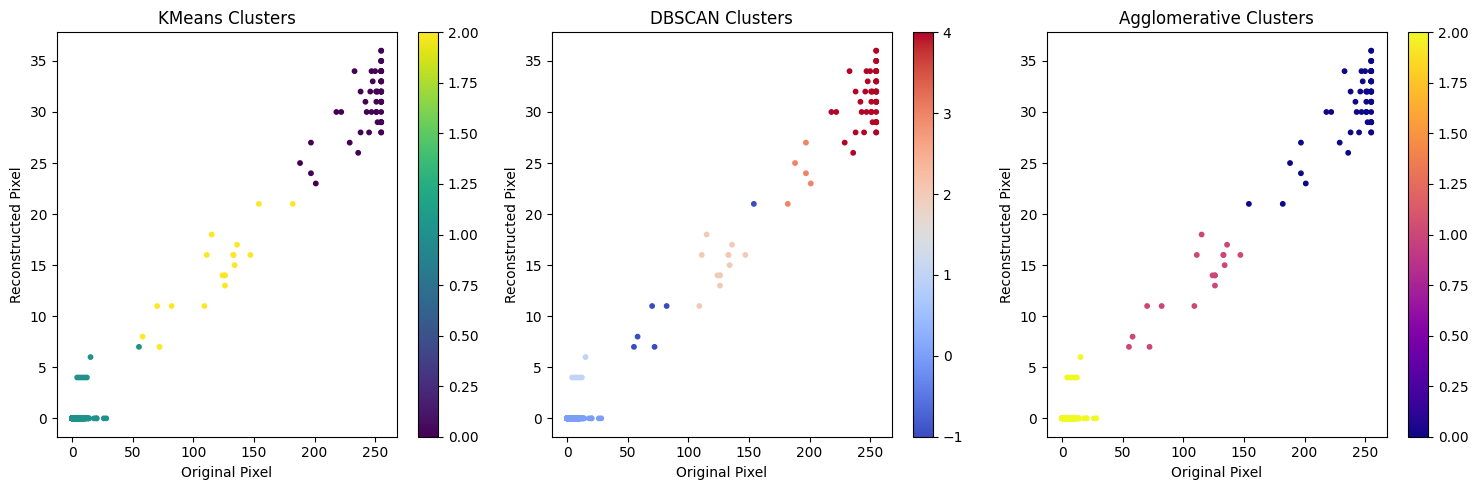

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

# --------- Load CSV ---------
df = pd.read_csv("pixel_values_FRQI.csv")

# Use Original and Reconstructed pixel values as features for clustering
# You can also add Normalized if needed
features = df[['Original(0-255)', 'Reconstructed(0-255)']].values

# Standardize features for clustering
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# --------- KMeans Clustering ---------
kmeans = KMeans(n_clusters=3, random_state=42)  # choose number of clusters
kmeans_labels = kmeans.fit_predict(features_scaled)

# --------- DBSCAN Clustering (density-based) ---------
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(features_scaled)

# --------- Agglomerative Clustering ---------
agglo = AgglomerativeClustering(n_clusters=3)
agglo_labels = agglo.fit_predict(features_scaled)

# --------- Add cluster labels to DataFrame ---------
df['KMeans_Cluster'] = kmeans_labels
df['DBSCAN_Cluster'] = dbscan_labels
df['Agglo_Cluster'] = agglo_labels

# --------- Visualize clusters ---------
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(df['Original(0-255)'], df['Reconstructed(0-255)'], c=df['KMeans_Cluster'], cmap='viridis', s=10)
plt.xlabel("Original Pixel")
plt.ylabel("Reconstructed Pixel")
plt.title("KMeans Clusters")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.scatter(df['Original(0-255)'], df['Reconstructed(0-255)'], c=df['DBSCAN_Cluster'], cmap='coolwarm', s=10)
plt.xlabel("Original Pixel")
plt.ylabel("Reconstructed Pixel")
plt.title("DBSCAN Clusters")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.scatter(df['Original(0-255)'], df['Reconstructed(0-255)'], c=df['Agglo_Cluster'], cmap='plasma', s=10)
plt.xlabel("Original Pixel")
plt.ylabel("Reconstructed Pixel")
plt.title("Agglomerative Clusters")
plt.colorbar()

plt.tight_layout()
plt.show()


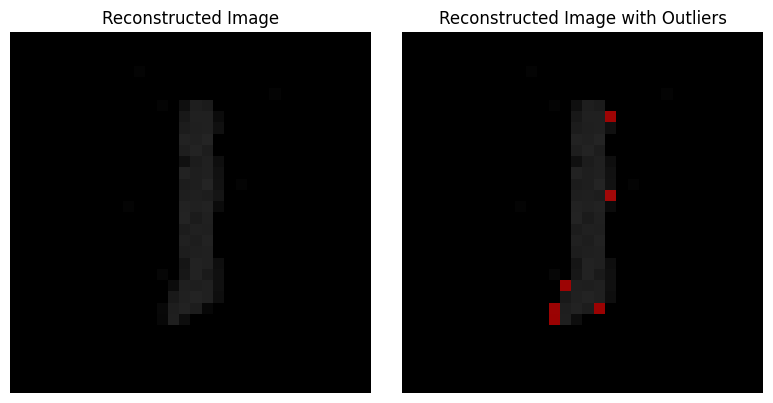

Number of outlier pixels detected by DBSCAN: 6


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# --------- Load CSV ---------
df = pd.read_csv("pixel_values_FRQI.csv")

# Use Original and Reconstructed pixel values as features
features = df[['Original(0-255)', 'Reconstructed(0-255)']].values

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply DBSCAN for outlier detection
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(features_scaled)
df['DBSCAN_Cluster'] = labels

# --------- Reconstruct the 32x32 image with outliers highlighted ---------
img_size = 32
block_size = 8
blocks_per_row = img_size // block_size

reconstructed_img = np.zeros((img_size, img_size), dtype=np.uint8)
outlier_mask = np.zeros((img_size, img_size), dtype=bool)

for _, row in df.iterrows():
    block_id = int(row['Block'])
    pixel_idx = int(row['PixelIndex'])
    r_block = block_id // blocks_per_row
    c_block = block_id % blocks_per_row
    r_pixel = pixel_idx // block_size
    c_pixel = pixel_idx % block_size
    r = r_block * block_size + r_pixel
    c = c_block * block_size + c_pixel

    reconstructed_img[r, c] = row['Reconstructed(0-255)']
    if row['DBSCAN_Cluster'] == -1:  # outlier
        outlier_mask[r, c] = True

# --------- Visualize ---------
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(reconstructed_img, cmap='gray', vmin=0, vmax=255)
plt.title("Reconstructed Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_img, cmap='gray', vmin=0, vmax=255)
# Overlay outliers in red
plt.imshow(np.ma.masked_where(~outlier_mask, outlier_mask), cmap='autumn', alpha=0.6)
plt.title("Reconstructed Image with Outliers")
plt.axis('off')

plt.tight_layout()
plt.show()

# --------- Print number of outliers ---------
num_outliers = np.sum(outlier_mask)
print(f"Number of outlier pixels detected by DBSCAN: {num_outliers}")


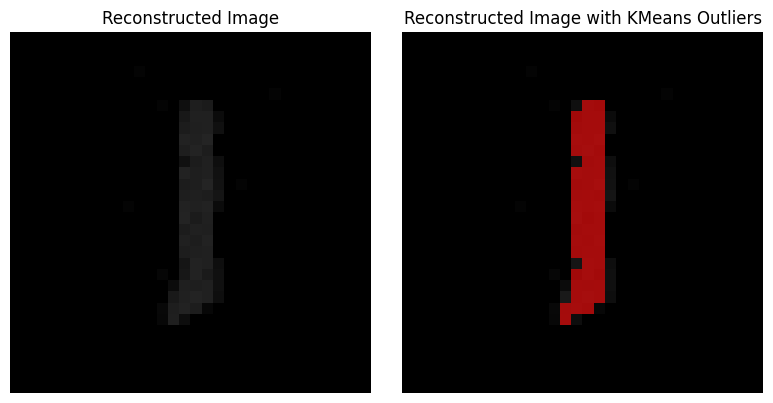

Number of outlier pixels detected by KMeans (high reconstruction error): 55


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# --------- Load CSV ---------
df = pd.read_csv("pixel_values_FRQI.csv")

# --------- Compute reconstruction error ---------
df['Error'] = np.abs(df['Original(0-255)'] - df['Reconstructed(0-255)'])

# --------- KMeans on errors to detect high-error pixels ---------
kmeans = KMeans(n_clusters=3, random_state=42)
df['KMeans_Cluster'] = kmeans.fit_predict(df[['Error']])

# Identify the cluster with the largest mean error as outliers
cluster_means = df.groupby('KMeans_Cluster')['Error'].mean()
outlier_cluster = cluster_means.idxmax()
df['KMeans_Outlier'] = df['KMeans_Cluster'] == outlier_cluster

# --------- Reconstruct 32x32 images ---------
img_size = 32
block_size = 8
blocks_per_row = img_size // block_size

reconstructed_img = np.zeros((img_size, img_size), dtype=np.uint8)
outlier_mask = np.zeros((img_size, img_size), dtype=bool)

for _, row in df.iterrows():
    block_id = int(row['Block'])
    pixel_idx = int(row['PixelIndex'])
    r_block = block_id // blocks_per_row
    c_block = block_id % blocks_per_row
    r_pixel = pixel_idx // block_size
    c_pixel = pixel_idx % block_size
    r = r_block * block_size + r_pixel
    c = c_block * block_size + c_pixel

    reconstructed_img[r, c] = row['Reconstructed(0-255)']
    if row['KMeans_Outlier']:
        outlier_mask[r, c] = True

# --------- Visualize ---------
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(reconstructed_img, cmap='gray', vmin=0, vmax=255)
plt.title("Reconstructed Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_img, cmap='gray', vmin=0, vmax=255)
plt.imshow(np.ma.masked_where(~outlier_mask, outlier_mask), cmap='autumn', alpha=0.6)
plt.title("Reconstructed Image with KMeans Outliers")
plt.axis('off')

plt.tight_layout()
plt.show()

# --------- Print summary ---------
num_outliers = np.sum(outlier_mask)
print(f"Number of outlier pixels detected by KMeans (high reconstruction error): {num_outliers}")

MSE (Optimized NEQR, 32x32): 0.0000


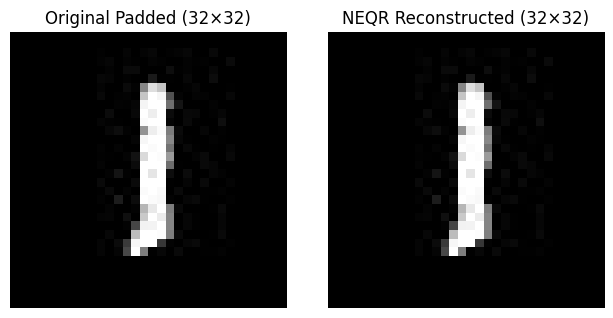

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import RYGate
from qiskit_aer import Aer
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def efficient_neqr_encode(circ, addr_qubits, color_qubits, block):
    """
    More efficient NEQR encoding using binary-controlled operations
    """
    n_pixels = block.size
    flat_pixels = block.flatten()

    # Hadamard superposition over address space
    for q in addr_qubits:
        circ.h(q)

    # Encode each pixel
    for i, pixel in enumerate(flat_pixels):
        addr_bin = format(i, f'0{len(addr_qubits)}b')
        pix_bin = format(int(pixel), '08b')

        # For each color qubit
        for bit_index, bit in enumerate(pix_bin):
            if bit == '1':
                # Create a multi-controlled X gate with the address as control
                controls = []
                for j, b in enumerate(addr_bin):
                    if b == '1':
                        controls.append(addr_qubits[j])
                    else:
                        # For 0-controlled, we need to add X gates
                        circ.x(addr_qubits[j])
                        controls.append(addr_qubits[j])

                # Apply the controlled operation
                if controls:  # If there are controls
                    circ.mcx(controls, color_qubits[bit_index])
                else:  # If no controls, just apply X
                    circ.x(color_qubits[bit_index])

                # Undo the X gates for 0-controlled qubits
                for j, b in enumerate(addr_bin):
                    if b == '0':
                        circ.x(addr_qubits[j])

def process_block_neqr_optimized(block8x8, shots=8192):
    addr_qubits = list(range(6))      # 6 for 8x8 addresses
    color_qubits = list(range(6, 14)) # 8 for grayscale values
    qr = QuantumRegister(14, 'q')
    cr = ClassicalRegister(14, 'c')
    qc = QuantumCircuit(qr, cr)

    efficient_neqr_encode(qc, addr_qubits, color_qubits, block8x8)

    # Measure all qubits
    qc.measure(qr, cr)

    # Run simulation
    backend = Aer.get_backend('qasm_simulator')
    tqc = transpile(qc, backend=backend)
    result = backend.run(tqc, shots=shots).result()
    counts = result.get_counts()

    # Decode measurement results into image
    # Use float64 for accumulation to avoid overflow
    reconstructed = np.zeros(64, dtype=np.float64)
    total_shots = 0

    for outcome, freq in counts.items():
        bits = outcome[::-1]  # Reverse for Qiskit bit order
        addr_bits = bits[0:6]
        color_bits = bits[6:14]
        addr_idx = int(addr_bits, 2)
        pixel_val = int(color_bits, 2)

        # Weight by frequency to get average value
        reconstructed[addr_idx] += pixel_val * freq
        total_shots += freq

    # Normalize by taking the average value for each pixel
    # Convert back to uint8 after ensuring values are in range
    reconstructed = (reconstructed / total_shots)
    # Clip values to ensure they're in [0, 255] range
    reconstructed = np.clip(reconstructed, 0, 255).astype(np.uint8)
    return reconstructed.reshape(8, 8)

# Alternative approach: use most frequent measurement instead of average
def process_block_neqr_most_frequent(block8x8, shots=8192):
    addr_qubits = list(range(6))      # 6 for 8x8 addresses
    color_qubits = list(range(6, 14)) # 8 for grayscale values
    qr = QuantumRegister(14, 'q')
    cr = ClassicalRegister(14, 'c')
    qc = QuantumCircuit(qr, cr)

    efficient_neqr_encode(qc, addr_qubits, color_qubits, block8x8)

    # Measure all qubits
    qc.measure(qr, cr)

    # Run simulation
    backend = Aer.get_backend('qasm_simulator')
    tqc = transpile(qc, backend=backend)
    result = backend.run(tqc, shots=shots).result()
    counts = result.get_counts()

    # Decode measurement results into image
    # Use dictionary to track most frequent measurement for each address
    pixel_dict = {}

    for outcome, freq in counts.items():
        bits = outcome[::-1]  # Reverse for Qiskit bit order
        addr_bits = bits[0:6]
        color_bits = bits[6:14]
        addr_idx = int(addr_bits, 2)
        pixel_val = int(color_bits, 2)

        # Track the most frequent measurement for each address
        if addr_idx not in pixel_dict or freq > pixel_dict[addr_idx][1]:
            pixel_dict[addr_idx] = (pixel_val, freq)

    # Create the reconstructed image
    reconstructed = np.zeros(64, dtype=np.uint8)
    for addr_idx, (pixel_val, _) in pixel_dict.items():
        reconstructed[addr_idx] = pixel_val

    return reconstructed.reshape(8, 8)

# Load and process image
def load_and_preprocess_image(path, target_size=(28, 28)):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Could not read the image at {path}")

    # Resize if needed
    if img.shape != target_size:
        img = cv2.resize(img, target_size, interpolation=cv2.INTER_NEAREST)

    # Pad to 32x32
    padded = np.pad(img, ((2, 2), (2, 2)), mode='constant', constant_values=0)
    return padded

# Main execution
def main():
    try:
        # Load and preprocess image
        padded32 = load_and_preprocess_image("/content/14.jpg")

        # Split into 8x8 blocks
        blocks = []
        for i in range(0, 32, 8):
            for j in range(0, 32, 8):
                blocks.append(padded32[i:i+8, j:j+8])
        blocks = np.array(blocks)

        # Process each block using the most frequent method (more stable)
        reconstructed_blocks = []
        for b in blocks:
            reconstructed_blocks.append(process_block_neqr_most_frequent(b, shots=8192))

        # Reshape and merge blocks
        reconstructed_blocks = np.array(reconstructed_blocks).reshape(4, 4, 8, 8)
        reconstructed32 = np.block([[reconstructed_blocks[i, j] for j in range(4)] for i in range(4)])

        # Compute MSE
        mse = mean_squared_error(padded32.flatten(), reconstructed32.flatten())
        print(f"MSE (Optimized NEQR, 32x32): {mse:.4f}")

        # Visualize
        fig, axs = plt.subplots(1, 2, figsize=(6.5, 3.2))
        axs[0].imshow(padded32, cmap='gray', vmin=0, vmax=255)
        axs[0].set_title("Original Padded (32×32)")
        axs[0].axis('off')
        axs[1].imshow(reconstructed32, cmap='gray', vmin=0, vmax=255)
        axs[1].set_title("NEQR Reconstructed (32×32)")
        axs[1].axis('off')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    main()

COMPLEXITY ANALYSIS: FRQI vs NEQR

TIME COMPLEXITY:
FRQI: O(N * 2^n) where N is pixels and n is address qubits
  - For each pixel: O(n) operations for address change
  - For each pixel: O(2^n) for n-controlled rotation
  - Overall: O(N * 2^n)

NEQR: O(N * n * 2^n) where N is pixels and n is address qubits
  - For each pixel: O(n) operations for address conditioning
  - For each color bit: O(2^n) for n-controlled X gate
  - 8 color bits per pixel → O(8 * n * 2^n) = O(N * n * 2^n)

SPACE COMPLEXITY (Qubits):
FRQI: n + 1 qubits (n address + 1 color)
NEQR: n + 8 qubits (n address + 8 color)

For 8x8 block (n=6, N=64):
FRQI operations: 4,096
NEQR operations: 24,576
Ratio (NEQR/FRQI): 6.0x

PERFORMANCE COMPARISON
FRQI - Time: 0.492s, Qubits: 7, Depth: 129, MSE: 22328.25
NEQR - Time: 0.146s, Qubits: 14, Depth: 561, MSE: 0.00


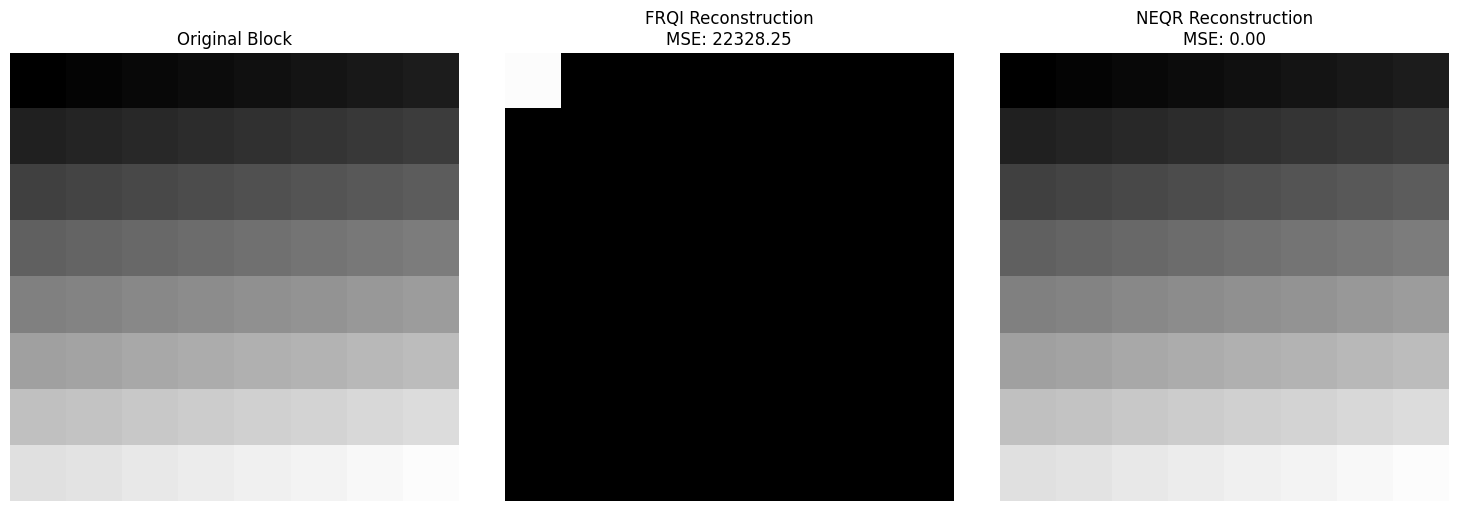

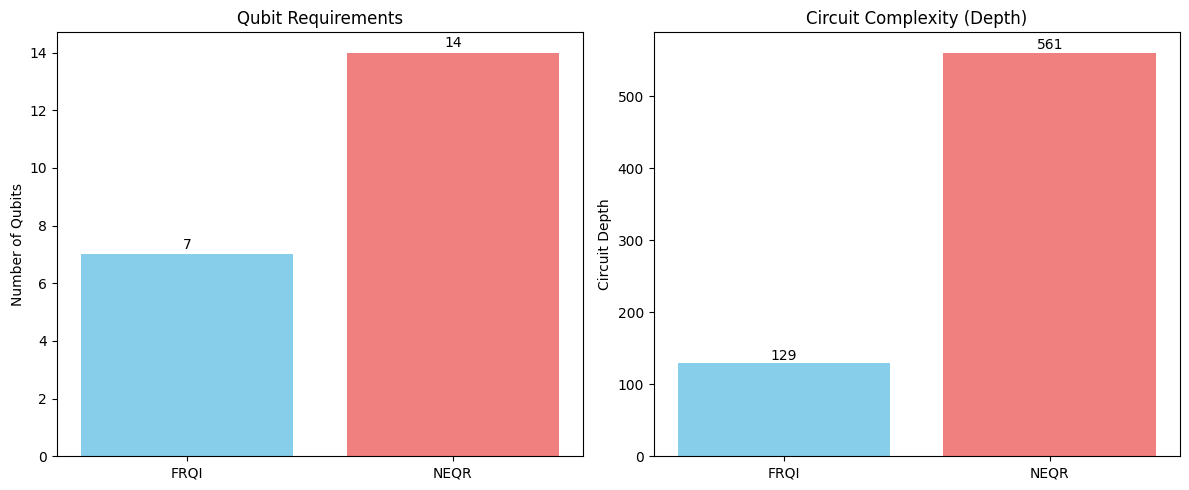


SCALABILITY ANALYSIS
Block size: 4x4 (n=2, N=16)
  FRQI operations: 64
  NEQR operations: 1,024
  Ratio (NEQR/FRQI): 16.0x

Block size: 8x8 (n=3, N=64)
  FRQI operations: 512
  NEQR operations: 12,288
  Ratio (NEQR/FRQI): 24.0x

Block size: 16x16 (n=4, N=256)
  FRQI operations: 4,096
  NEQR operations: 131,072
  Ratio (NEQR/FRQI): 32.0x

Block size: 32x32 (n=5, N=1024)
  FRQI operations: 32,768
  NEQR operations: 1,310,720
  Ratio (NEQR/FRQI): 40.0x



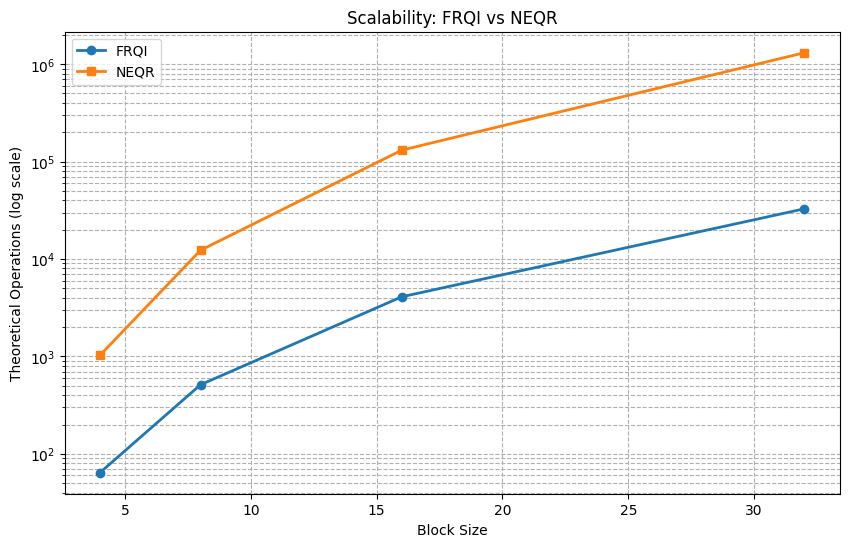


KEY INSIGHTS
1. FRQI uses fewer qubits but requires more shots for accurate reconstruction
2. NEQR uses more qubits but provides more accurate reconstruction with fewer shots
3. FRQI has better theoretical scaling but suffers from measurement uncertainty
4. NEQR has worse theoretical scaling but produces deterministic results
5. For small images, FRQI may be preferable due to lower qubit requirements
6. For accurate reconstruction, NEQR is generally superior despite higher circuit complexity


In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_aer import Aer
from qiskit.circuit.library import RYGate
import cv2

# ===================== FRQI Implementation =====================
def change(state, new_state):
    """Find indices where bits differ between two strings"""
    return [i for i in range(len(state)) if state[i] != new_state[i]]

def binary(circ, state, new_state):
    """Flip qubits to change from state to new_state"""
    c = change(state, new_state)
    if len(c) > 0:
        n_bits = len(state)
        circ.x([n_bits - 1 - idx for idx in c])

def frqi(qc, addr_qubits, color_qubit, angles):
    """FRQI encoding implementation"""
    n = len(addr_qubits)
    # Initialize with all zeros
    current_state = '0' * n

    for i, angle in enumerate(angles):
        # Convert to binary address
        new_state = format(i, f'0{n}b')

        # Apply X gates to change address
        binary(qc, current_state, new_state)
        current_state = new_state

        # Apply controlled rotation
        control_qubits = [addr_qubits[j] for j in range(n)]
        controlled_ry = RYGate(2 * angle).control(n)
        qc.append(controlled_ry, control_qubits + [color_qubit])

    # Return to zero state
    binary(qc, current_state, '0' * n)

def process_block_frqi(block8x8, shots=65536):
    """Process a single 8x8 block using FRQI"""
    norm_block = (block8x8.astype(np.float64) / 255.0)
    angles = np.arcsin(norm_block.flatten())

    addr_qubits = list(range(6))
    color_qubit = 6
    qr = QuantumRegister(7, 'q')
    cr = ClassicalRegister(7, 'c')
    qc = QuantumCircuit(qr, cr)

    frqi(qc, addr_qubits, color_qubit, angles)
    qc.measure([0,1,2,3,4,5,6], [0,1,2,3,4,5,6])

    backend = Aer.get_backend('qasm_simulator')
    tqc = transpile(qc, backend=backend)
    result = backend.run(tqc, shots=shots).result()
    counts = result.get_counts(qc)

    retrieved = np.zeros(64, dtype=np.float64)
    for i in range(64):
        s = format(i, '06b')
        key = '1' + s
        p1 = counts.get(key, 0) / shots
        retrieved[i] = np.sqrt(p1)

    retrieved *= 255.0
    block_rec = np.clip(np.round(retrieved), 0, 255).astype(np.uint8).reshape(8, 8)
    return block_rec, qc

# ===================== NEQR Implementation =====================
def efficient_neqr_encode(circ, addr_qubits, color_qubits, block):
    """NEQR encoding implementation"""
    n_pixels = block.size
    flat_pixels = block.flatten()

    # Hadamard superposition over address space
    for q in addr_qubits:
        circ.h(q)

    # Encode each pixel
    for i, pixel in enumerate(flat_pixels):
        addr_bin = format(i, f'0{len(addr_qubits)}b')
        pix_bin = format(int(pixel), '08b')

        # For each color qubit
        for bit_index, bit in enumerate(pix_bin):
            if bit == '1':
                # Create a multi-controlled X gate with the address as control
                controls = []
                for j, b in enumerate(addr_bin):
                    if b == '1':
                        controls.append(addr_qubits[j])
                    else:
                        circ.x(addr_qubits[j])
                        controls.append(addr_qubits[j])

                # Apply the controlled operation
                if controls:
                    circ.mcx(controls, color_qubits[bit_index])
                else:
                    circ.x(color_qubits[bit_index])

                # Undo the X gates for 0-controlled qubits
                for j, b in enumerate(addr_bin):
                    if b == '0':
                        circ.x(addr_qubits[j])

def process_block_neqr(block8x8, shots=8192):
    """Process a single 8x8 block using NEQR"""
    addr_qubits = list(range(6))
    color_qubits = list(range(6, 14))
    qr = QuantumRegister(14, 'q')
    cr = ClassicalRegister(14, 'c')
    qc = QuantumCircuit(qr, cr)

    efficient_neqr_encode(qc, addr_qubits, color_qubits, block8x8)
    qc.measure(qr, cr)

    backend = Aer.get_backend('qasm_simulator')
    tqc = transpile(qc, backend=backend)
    result = backend.run(tqc, shots=shots).result()
    counts = result.get_counts()

    # Use most frequent measurement approach
    pixel_dict = {}

    for outcome, freq in counts.items():
        bits = outcome[::-1]  # Reverse for Qiskit bit order
        addr_bits = bits[0:6]
        color_bits = bits[6:14]
        addr_idx = int(addr_bits, 2)
        pixel_val = int(color_bits, 2)

        if addr_idx not in pixel_dict or freq > pixel_dict[addr_idx][1]:
            pixel_dict[addr_idx] = (pixel_val, freq)

    reconstructed = np.zeros(64, dtype=np.uint8)
    for addr_idx, (pixel_val, _) in pixel_dict.items():
        reconstructed[addr_idx] = pixel_val

    return reconstructed.reshape(8, 8), qc

# ===================== Complexity Analysis =====================
def analyze_complexity():
    """Analyze time and space complexity of both algorithms"""
    print("=" * 60)
    print("COMPLEXITY ANALYSIS: FRQI vs NEQR")
    print("=" * 60)

    # Time complexity analysis
    print("\nTIME COMPLEXITY:")
    print("FRQI: O(N * 2^n) where N is pixels and n is address qubits")
    print("  - For each pixel: O(n) operations for address change")
    print("  - For each pixel: O(2^n) for n-controlled rotation")
    print("  - Overall: O(N * 2^n)")

    print("\nNEQR: O(N * n * 2^n) where N is pixels and n is address qubits")
    print("  - For each pixel: O(n) operations for address conditioning")
    print("  - For each color bit: O(2^n) for n-controlled X gate")
    print("  - 8 color bits per pixel → O(8 * n * 2^n) = O(N * n * 2^n)")

    # Space complexity analysis
    print("\nSPACE COMPLEXITY (Qubits):")
    print("FRQI: n + 1 qubits (n address + 1 color)")
    print("NEQR: n + 8 qubits (n address + 8 color)")

    # For 8x8 block (n=6)
    n = 6
    N = 64
    frqi_time = N * (2**n)
    neqr_time = N * n * (2**n)

    print(f"\nFor 8x8 block (n={n}, N={N}):")
    print(f"FRQI operations: {frqi_time:,}")
    print(f"NEQR operations: {neqr_time:,}")
    print(f"Ratio (NEQR/FRQI): {neqr_time/frqi_time:.1f}x")

    return frqi_time, neqr_time

# ===================== Performance Comparison =====================
def compare_performance():
    """Compare actual performance of FRQI and NEQR"""
    print("\n" + "=" * 60)
    print("PERFORMANCE COMPARISON")
    print("=" * 60)

    # Create a simple test pattern (gradient)
    test_block = np.zeros((8, 8), dtype=np.uint8)
    for i in range(8):
        for j in range(8):
            test_block[i, j] = (i * 8 + j) * 4  # Values from 0 to 252

    # Measure FRQI performance
    start_time = time.time()
    frqi_result, frqi_circuit = process_block_frqi(test_block, shots=2048)
    frqi_time = time.time() - start_time
    frqi_qubits = frqi_circuit.num_qubits
    frqi_depth = frqi_circuit.depth()

    # Measure NEQR performance
    start_time = time.time()
    neqr_result, neqr_circuit = process_block_neqr(test_block, shots=2048)
    neqr_time = time.time() - start_time
    neqr_qubits = neqr_circuit.num_qubits
    neqr_depth = neqr_circuit.depth()

    # Calculate MSE
    frqi_mse = mean_squared_error(test_block.flatten(), frqi_result.flatten())
    neqr_mse = mean_squared_error(test_block.flatten(), neqr_result.flatten())

    print(f"FRQI - Time: {frqi_time:.3f}s, Qubits: {frqi_qubits}, Depth: {frqi_depth}, MSE: {frqi_mse:.2f}")
    print(f"NEQR - Time: {neqr_time:.3f}s, Qubits: {neqr_qubits}, Depth: {neqr_depth}, MSE: {neqr_mse:.2f}")

    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(test_block, cmap='gray', vmin=0, vmax=255)
    axes[0].set_title("Original Block")
    axes[0].axis('off')

    axes[1].imshow(frqi_result, cmap='gray', vmin=0, vmax=255)
    axes[1].set_title(f"FRQI Reconstruction\nMSE: {frqi_mse:.2f}")
    axes[1].axis('off')

    axes[2].imshow(neqr_result, cmap='gray', vmin=0, vmax=255)
    axes[2].set_title(f"NEQR Reconstruction\nMSE: {neqr_mse:.2f}")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    # Circuit complexity comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Qubit count comparison
    algorithms = ['FRQI', 'NEQR']
    qubits = [frqi_qubits, neqr_qubits]
    bars = ax1.bar(algorithms, qubits, color=['skyblue', 'lightcoral'])
    ax1.set_ylabel('Number of Qubits')
    ax1.set_title('Qubit Requirements')
    for bar, value in zip(bars, qubits):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{value}', ha='center', va='bottom')

    # Circuit depth comparison
    depth = [frqi_depth, neqr_depth]
    bars = ax2.bar(algorithms, depth, color=['skyblue', 'lightcoral'])
    ax2.set_ylabel('Circuit Depth')
    ax2.set_title('Circuit Complexity (Depth)')
    for bar, value in zip(bars, depth):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{value}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    return {
        'frqi': {'time': frqi_time, 'qubits': frqi_qubits, 'depth': frqi_depth, 'mse': frqi_mse},
        'neqr': {'time': neqr_time, 'qubits': neqr_qubits, 'depth': neqr_depth, 'mse': neqr_mse}
    }

# ===================== Scalability Analysis =====================
def scalability_analysis():
    """Analyze how algorithms scale with image size"""
    print("\n" + "=" * 60)
    print("SCALABILITY ANALYSIS")
    print("=" * 60)

    sizes = [4, 8, 16, 32]  # Different block sizes to test
    frqi_ops = []
    neqr_ops = []

    for size in sizes:
        n = int(np.log2(size))  # Address qubits needed
        N = size * size  # Number of pixels

        # Theoretical operations count
        frqi_op_count = N * (2**n)  # FRQI operations
        neqr_op_count = N * n * (2**n) * 8  # NEQR operations (8 color bits)

        frqi_ops.append(frqi_op_count)
        neqr_ops.append(neqr_op_count)

        print(f"Block size: {size}x{size} (n={n}, N={N})")
        print(f"  FRQI operations: {frqi_op_count:,}")
        print(f"  NEQR operations: {neqr_op_count:,}")
        print(f"  Ratio (NEQR/FRQI): {neqr_op_count/frqi_op_count:.1f}x")
        print()

    # Plot scalability
    plt.figure(figsize=(10, 6))
    plt.plot(sizes, frqi_ops, 'o-', label='FRQI', linewidth=2)
    plt.plot(sizes, neqr_ops, 's-', label='NEQR', linewidth=2)
    plt.yscale('log')
    plt.xlabel('Block Size')
    plt.ylabel('Theoretical Operations (log scale)')
    plt.title('Scalability: FRQI vs NEQR')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

# ===================== Main Execution =====================
if __name__ == "__main__":
    # Analyze theoretical complexity
    analyze_complexity()

    # Compare actual performance
    performance = compare_performance()

    # Analyze scalability
    scalability_analysis()

    print("\n" + "=" * 60)
    print("KEY INSIGHTS")
    print("=" * 60)
    print("1. FRQI uses fewer qubits but requires more shots for accurate reconstruction")
    print("2. NEQR uses more qubits but provides more accurate reconstruction with fewer shots")
    print("3. FRQI has better theoretical scaling but suffers from measurement uncertainty")
    print("4. NEQR has worse theoretical scaling but produces deterministic results")
    print("5. For small images, FRQI may be preferable due to lower qubit requirements")
    print("6. For accurate reconstruction, NEQR is generally superior despite higher circuit complexity")

FRQI Avg Time per Block: 0.5576s
NEQR Avg Time per Block: 0.1282s
FRQI MSE: 3172.8203
NEQR MSE: 3503.1729
FRQI Qubits per Block: 7
NEQR Qubits per Block: 14
FRQI Circuit Complexity (gates): 197.0
NEQR Circuit Complexity (gates): 359.3


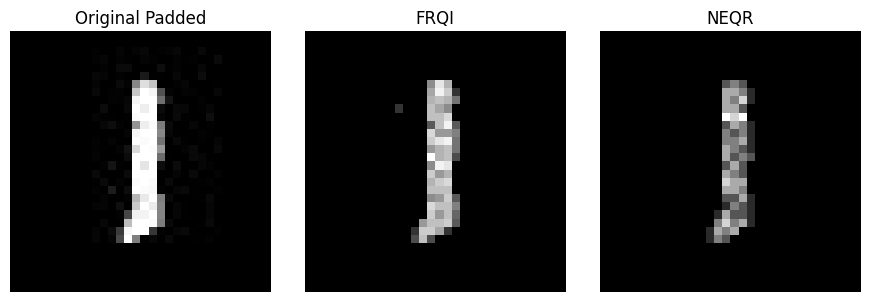

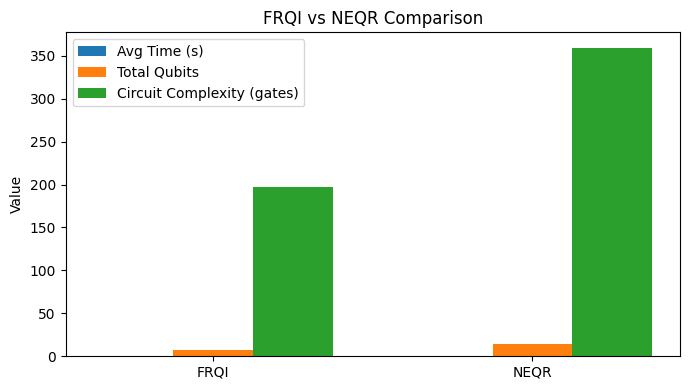

In [ ]:
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import  Aer
from qiskit.circuit.library import RYGate

# ---------------- FRQI Functions ----------------
def hadamard(circ, n):
    for i in n:
        circ.h(i)

def change(state, new_state):
    return np.array([i for i in range(len(state)) if state[i] != new_state[i]], dtype=int)

def binary(circ, state, new_state):
    c = change(state, new_state)
    if len(c) > 0:
        n_bits = len(state)
        circ.x([n_bits - 1 - idx for idx in c])

def cnri(circ, n, t, theta):
    controls = len(n)
    cry = RYGate(2*theta).control(controls)
    circ.append(cry, np.append(n, t).tolist())

def frqi(circ, n, t, angles):
    hadamard(circ, n)
    for j, theta in enumerate(angles):
        state = '{0:06b}'.format(j-1) if j > 0 else '000000'
        new_state = '{0:06b}'.format(j)
        if j == 0:
            cnri(circ, n, t, theta)
        else:
            binary(circ, state, new_state)
            cnri(circ, n, t, theta)

def process_block_frqi(block8x8, shots=4096):
    norm_block = block8x8.astype(np.float64)/255.0
    angles = np.arcsin(norm_block.flatten())
    addr_qubits = list(range(6))
    color_qubit = 6
    qr = QuantumRegister(7)
    cr = ClassicalRegister(7)
    qc = QuantumCircuit(qr, cr)
    frqi(qc, addr_qubits, color_qubit, angles)
    qc.measure(qr, cr)
    backend = Aer.get_backend('qasm_simulator')
    result = backend.run(transpile(qc, backend)).result()
    counts = result.get_counts()
    retrieved = np.zeros(64, dtype=np.float64)
    for i in range(64):
        key = '1'+format(i,'06b')
        retrieved[i] = np.sqrt(counts.get(key,0)/shots)
    return np.clip(np.round(retrieved*255),0,255).astype(np.uint8).reshape(8,8), qc

# ---------------- NEQR Functions ----------------
def efficient_neqr_encode(circ, addr_qubits, color_qubits, block):
    flat_pixels = block.flatten()
    for q in addr_qubits:
        circ.h(q)
    for i, pixel in enumerate(flat_pixels):
        addr_bin = format(i, f'0{len(addr_qubits)}b')
        pix_bin = format(int(pixel), '08b')
        for bit_index, bit in enumerate(pix_bin):
            if bit=='1':
                controls=[]
                for j,b in enumerate(addr_bin):
                    if b=='1':
                        controls.append(addr_qubits[j])
                    else:
                        circ.x(addr_qubits[j])
                        controls.append(addr_qubits[j])
                if controls:
                    circ.mcx(controls, color_qubits[bit_index])
                else:
                    circ.x(color_qubits[bit_index])
                for j,b in enumerate(addr_bin):
                    if b=='0':
                        circ.x(addr_qubits[j])

def process_block_neqr(block8x8, shots=4096):
    addr_qubits = list(range(6))
    color_qubits = list(range(6,14))
    qr = QuantumRegister(14)
    cr = ClassicalRegister(14)
    qc = QuantumCircuit(qr, cr)
    efficient_neqr_encode(qc, addr_qubits, color_qubits, block8x8)
    qc.measure(qr, cr)
    backend = Aer.get_backend('qasm_simulator')
    result = backend.run(transpile(qc, backend)).result()
    counts = result.get_counts()
    reconstructed = np.zeros(64,dtype=np.float64)
    total_shots = 0
    for outcome,freq in counts.items():
        bits = outcome[::-1]
        addr_idx = int(bits[:6],2)
        pixel_val = int(bits[6:],2)
        reconstructed[addr_idx] += pixel_val*freq
        total_shots += freq
    reconstructed = np.clip(reconstructed/total_shots,0,255).astype(np.uint8)
    return reconstructed.reshape(8,8), qc

# ---------------- Image Preprocessing ----------------
def load_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img,(28,28),interpolation=cv2.INTER_NEAREST)
    padded = np.pad(img, ((2,2),(2,2)), mode='constant', constant_values=0)
    blocks = [padded[i:i+8,j:j+8] for i in range(0,32,8) for j in range(0,32,8)]
    return padded, np.array(blocks)

# ---------------- Main: Compare ----------------
padded32, blocks = load_image("/content/14.jpg")

frqi_times = []
neqr_times = []
frqi_qubits = []
neqr_qubits = []
frqi_gates = []
neqr_gates = []

recon_frqi = []
recon_neqr = []

for b in blocks:
    t0 = time.time()
    r_block, qc_frqi = process_block_frqi(b)
    frqi_times.append(time.time()-t0)
    recon_frqi.append(r_block)
    frqi_qubits.append(qc_frqi.num_qubits)
    frqi_gates.append(qc_frqi.size())

    t1 = time.time()
    r_block, qc_neqr = process_block_neqr(b)
    neqr_times.append(time.time()-t1)
    recon_neqr.append(r_block)
    neqr_qubits.append(qc_neqr.num_qubits)
    neqr_gates.append(qc_neqr.size())

recon_frqi = np.block([[recon_frqi[i*4+j] for j in range(4)] for i in range(4)])
recon_neqr = np.block([[recon_neqr[i*4+j] for j in range(4)] for i in range(4)])

# ---------------- Metrics ----------------
print(f"FRQI Avg Time per Block: {np.mean(frqi_times):.4f}s")
print(f"NEQR Avg Time per Block: {np.mean(neqr_times):.4f}s")
print(f"FRQI MSE: {mean_squared_error(padded32.flatten(), recon_frqi.flatten()):.4f}")
print(f"NEQR MSE: {mean_squared_error(padded32.flatten(), recon_neqr.flatten()):.4f}")
print(f"FRQI Qubits per Block: {np.max(frqi_qubits)}")
print(f"NEQR Qubits per Block: {np.max(neqr_qubits)}")
print(f"FRQI Circuit Complexity (gates): {np.mean(frqi_gates):.1f}")
print(f"NEQR Circuit Complexity (gates): {np.mean(neqr_gates):.1f}")

# ---------------- Visualization ----------------
fig, axs = plt.subplots(1,3,figsize=(9,3))
axs[0].imshow(padded32,cmap='gray'); axs[0].set_title("Original Padded"); axs[0].axis('off')
axs[1].imshow(recon_frqi,cmap='gray'); axs[1].set_title("FRQI"); axs[1].axis('off')
axs[2].imshow(recon_neqr,cmap='gray'); axs[2].set_title("NEQR"); axs[2].axis('off')
plt.tight_layout()
plt.show()

# ---------------- Bar Graphs ----------------
import matplotlib.pyplot as plt

labels = ['FRQI', 'NEQR']
avg_time = [np.mean(frqi_times), np.mean(neqr_times)]
num_qubits = [np.max(frqi_qubits), np.max(neqr_qubits)]
circuit_gates = [np.mean(frqi_gates), np.mean(neqr_gates)]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(7,4))
ax.bar(x - width, avg_time, width, label='Avg Time (s)')
ax.bar(x, num_qubits, width, label='Total Qubits')
ax.bar(x + width, circuit_gates, width, label='Circuit Complexity (gates)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Value")
ax.set_title("FRQI vs NEQR Comparison")
ax.legend()
plt.tight_layout()
plt.show()

------ FRQI vs NEQR Comparison ------
FRQI Avg Time per Block: 0.6856s
NEQR Avg Time per Block: 0.1629s
FRQI MSE: 2755.9199
NEQR MSE: 0.0000
FRQI Total Qubits per Block: 7
NEQR Total Qubits per Block: 14
FRQI Circuit Complexity (gates): 190.0
NEQR Circuit Complexity (gates): 345.3

--- Theoretical Complexity (Big-O) ---
FRQI: O(2^n) controlled-Ry gates per block (n = log2(num_pixels) = 6 for 8x8 block)
NEQR: O(2^n * m) multi-controlled X gates per block (n=6 addr, m=8 color bits)


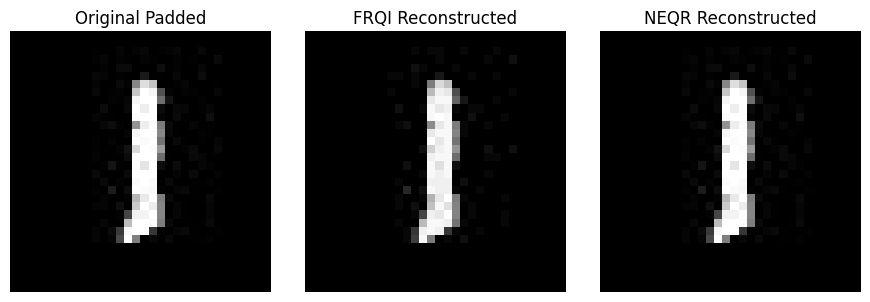

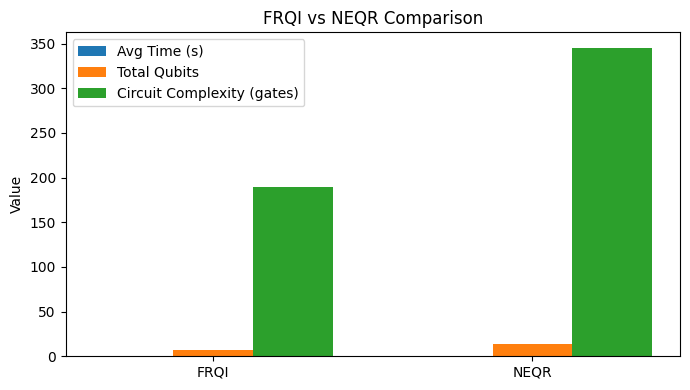

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import time

# ---------------- Wrapper: Compare FRQI and NEQR ----------------
def compare_frqi_neqr(blocks, shots_frqi=65536, shots_neqr=8192):
    frqi_times = []
    neqr_times = []
    frqi_qubits = []
    neqr_qubits = []
    frqi_gates = []
    neqr_gates = []
    recon_frqi = []
    recon_neqr = []

    for b in blocks:
        # ---- FRQI ----
        t0 = time.time()
        rec_block = process_block(b, shots=shots_frqi)  # existing FRQI function
        frqi_times.append(time.time()-t0)
        recon_frqi.append(rec_block)
        # Get qubits and gate count from the circuit (re-run FRQI circuit without measurement)
        from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
        addr_qubits = list(range(6))
        color_qubit = 6
        qr = QuantumRegister(7)
        cr = ClassicalRegister(7)
        qc = QuantumCircuit(qr, cr)
        frqi(qc, addr_qubits, color_qubit, np.arcsin((b.astype(np.float64)/255.0).flatten()))
        frqi_qubits.append(qc.num_qubits)
        frqi_gates.append(qc.size())

        # ---- NEQR ----
        t1 = time.time()
        rec_block = process_block_neqr_most_frequent(b, shots=shots_neqr)  # existing NEQR function
        neqr_times.append(time.time()-t1)
        recon_neqr.append(rec_block)
        qr = QuantumRegister(14)
        cr = ClassicalRegister(14)
        qc = QuantumCircuit(qr, cr)
        efficient_neqr_encode(qc, list(range(6)), list(range(6,14)), b)
        neqr_qubits.append(qc.num_qubits)
        neqr_gates.append(qc.size())

    recon_frqi_img = np.block([[recon_frqi[i*4+j] for j in range(4)] for i in range(4)])
    recon_neqr_img = np.block([[recon_neqr[i*4+j] for j in range(4)] for i in range(4)])

    # ---------------- Metrics ----------------
    print("------ FRQI vs NEQR Comparison ------")
    print(f"FRQI Avg Time per Block: {np.mean(frqi_times):.4f}s")
    print(f"NEQR Avg Time per Block: {np.mean(neqr_times):.4f}s")
    print(f"FRQI MSE: {mean_squared_error(padded32.flatten(), recon_frqi_img.flatten()):.4f}")
    print(f"NEQR MSE: {mean_squared_error(padded32.flatten(), recon_neqr_img.flatten()):.4f}")
    print(f"FRQI Total Qubits per Block: {np.max(frqi_qubits)}")
    print(f"NEQR Total Qubits per Block: {np.max(neqr_qubits)}")
    print(f"FRQI Circuit Complexity (gates): {np.mean(frqi_gates):.1f}")
    print(f"NEQR Circuit Complexity (gates): {np.mean(neqr_gates):.1f}")

    # Theoretical Big-O
    print("\n--- Theoretical Complexity (Big-O) ---")
    print("FRQI: O(2^n) controlled-Ry gates per block (n = log2(num_pixels) = 6 for 8x8 block)")
    print("NEQR: O(2^n * m) multi-controlled X gates per block (n=6 addr, m=8 color bits)")

    # ---------------- Visualization ----------------
    fig, axs = plt.subplots(1,3,figsize=(9,3))
    axs[0].imshow(padded32, cmap='gray'); axs[0].set_title("Original Padded"); axs[0].axis('off')
    axs[1].imshow(recon_frqi_img, cmap='gray'); axs[1].set_title("FRQI Reconstructed"); axs[1].axis('off')
    axs[2].imshow(recon_neqr_img, cmap='gray'); axs[2].set_title("NEQR Reconstructed"); axs[2].axis('off')
    plt.tight_layout()
    plt.show()

    # ---------------- Bar Graph ----------------
    labels = ['FRQI', 'NEQR']
    avg_time = [np.mean(frqi_times), np.mean(neqr_times)]
    num_qubits = [np.max(frqi_qubits), np.max(neqr_qubits)]
    circuit_gates = [np.mean(frqi_gates), np.mean(neqr_gates)]

    x = np.arange(len(labels))
    width = 0.25

    fig, ax = plt.subplots(figsize=(7,4))
    ax.bar(x - width, avg_time, width, label='Avg Time (s)')
    ax.bar(x, num_qubits, width, label='Total Qubits')
    ax.bar(x + width, circuit_gates, width, label='Circuit Complexity (gates)')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel("Value")
    ax.set_title("FRQI vs NEQR Comparison")
    ax.legend()
    plt.tight_layout()
    plt.show()

    return recon_frqi_img, recon_neqr_img

# ---------------- Usage ----------------
# padded32 and blocks already defined in your code
recon_frqi_img, recon_neqr_img = compare_frqi_neqr(blocks)


Padded/Resized image to 64x64
MSE (NEQR): 0.0000


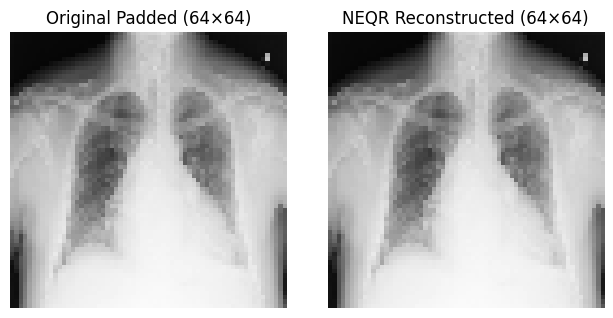

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import Aer
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math

# ====================== NEQR Encoding ======================
def efficient_neqr_encode(circ, addr_qubits, color_qubits, block):
    n_pixels = block.size
    flat_pixels = block.flatten()

    # Hadamard superposition over address space
    for q in addr_qubits:
        circ.h(q)

    # Encode each pixel
    for i, pixel in enumerate(flat_pixels):
        addr_bin = format(i, f'0{len(addr_qubits)}b')
        pix_bin = format(int(pixel), '08b')

        for bit_index, bit in enumerate(pix_bin):
            if bit == '1':
                controls = []
                for j, b in enumerate(addr_bin):
                    if b == '1':
                        controls.append(addr_qubits[j])
                    else:
                        circ.x(addr_qubits[j])
                        controls.append(addr_qubits[j])

                if controls:
                    circ.mcx(controls, color_qubits[bit_index])
                else:
                    circ.x(color_qubits[bit_index])

                for j, b in enumerate(addr_bin):
                    if b == '0':
                        circ.x(addr_qubits[j])

# ====================== Image Preprocessing ======================
def next_power_of_2(n):
    """Return next power of 2 greater than or equal to n"""
    return 1 if n == 0 else 2**(math.ceil(math.log2(n)))

def pad_or_downsample(img, target_size=None):
    """Pad or resize the image to a square of size power of 2"""
    h, w = img.shape
    if target_size is None:
        size = next_power_of_2(max(h, w))
    else:
        size = target_size

    # Resize if larger
    if h > size or w > size:
        img = cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)
    else:
        # Pad if smaller
        pad_h = size - h
        pad_w = size - w
        img = np.pad(img, ((0, pad_h), (0, pad_w)), mode='constant', constant_values=0)

    return img, size

# ====================== Block Processing ======================
def process_block_neqr(block, shots=8192):
    """NEQR processing using most frequent measurement"""
    n_pixels = block.size
    n_addr = int(math.ceil(math.log2(n_pixels)))
    addr_qubits = list(range(n_addr))
    color_qubits = list(range(n_addr, n_addr + 8))
    qr = QuantumRegister(n_addr + 8, 'q')
    cr = ClassicalRegister(n_addr + 8, 'c')
    qc = QuantumCircuit(qr, cr)

    efficient_neqr_encode(qc, addr_qubits, color_qubits, block)
    qc.measure(qr, cr)

    backend = Aer.get_backend('qasm_simulator')
    result = backend.run(transpile(qc, backend=backend), shots=shots).result()
    counts = result.get_counts()

    # Most frequent method
    pixel_dict = {}
    for outcome, freq in counts.items():
        bits = outcome[::-1]
        addr_bits = bits[0:n_addr]
        color_bits = bits[n_addr:n_addr+8]
        addr_idx = int(addr_bits, 2)
        pixel_val = int(color_bits, 2)
        if addr_idx not in pixel_dict or freq > pixel_dict[addr_idx][1]:
            pixel_dict[addr_idx] = (pixel_val, freq)

    reconstructed = np.zeros(n_pixels, dtype=np.uint8)
    for idx, (val, _) in pixel_dict.items():
        reconstructed[idx] = val
    return reconstructed.reshape(block.shape)

# ====================== Main Execution ======================
def main():
    path = "/content/resized-64x64-image.png"
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Could not read the image at {path}")

    # Pad/Downsample to next power of 2
    padded_img, size = pad_or_downsample(img)
    print(f"Padded/Resized image to {size}x{size}")

    # Determine block size (e.g., 2, 4, 8, 16)
    block_size = min(8, size)  # can adjust based on memory constraints
    blocks_per_side = size // block_size

    # Split into blocks
    blocks = []
    for i in range(0, size, block_size):
        for j in range(0, size, block_size):
            blocks.append(padded_img[i:i+block_size, j:j+block_size])

    # Process each block
    reconstructed_blocks = []
    for b in blocks:
        reconstructed_blocks.append(process_block_neqr(b, shots=8192))

    # Merge blocks
    reconstructed_blocks = np.array(reconstructed_blocks).reshape(blocks_per_side, blocks_per_side, block_size, block_size)
    reconstructed_img = np.block([[reconstructed_blocks[i, j] for j in range(blocks_per_side)] for i in range(blocks_per_side)])

    # Compute MSE
    mse = mean_squared_error(padded_img.flatten(), reconstructed_img.flatten())
    print(f"MSE (NEQR): {mse:.4f}")

    # Visualize
    fig, axs = plt.subplots(1, 2, figsize=(6.5, 3.2))
    axs[0].imshow(padded_img, cmap='gray', vmin=0, vmax=255)
    axs[0].set_title(f"Original Padded ({size}×{size})")
    axs[0].axis('off')
    axs[1].imshow(reconstructed_img, cmap='gray', vmin=0, vmax=255)
    axs[1].set_title(f"NEQR Reconstructed ({size}×{size})")
    axs[1].axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
